In [1]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Text cleaning
import re
import string
import demoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

In [3]:
# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

In [4]:
# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [5]:
# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [6]:
# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

# Preprocessing

In [7]:
df = pd.read_csv('cyberbullying_tweets.csv')

df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df = df[~df.duplicated()]

In [9]:
# Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

In [10]:
# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

In [11]:
# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

In [12]:
# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

In [13]:
def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

In [14]:
# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [15]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [16]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')
df.drop_duplicates("text_clean", inplace=True)

There are around 6264 duplicated tweets, we will remove them.


In [17]:
df.to_csv('cleaned_cyberbullying_tweets.csv', index = False)

In [18]:
df1 = pd.read_csv('cleaned_cyberbullying_tweets.csv')

In [19]:
df.sentiment.value_counts()

religion               7914
age                    7814
ethnicity              7410
gender                 7274
not_cyberbullying      6076
other_cyberbullying    4904
Name: sentiment, dtype: int64

In [20]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [21]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [22]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

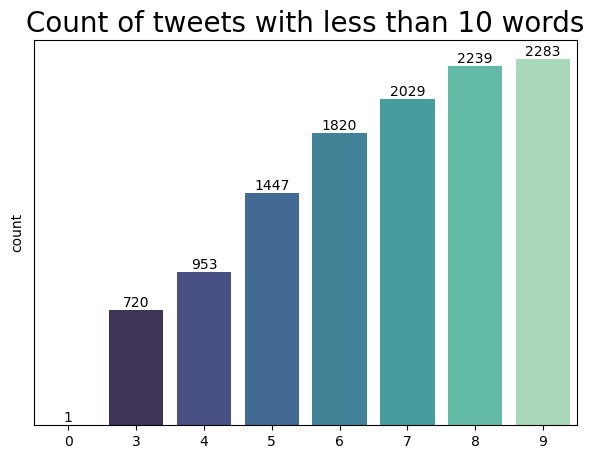

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [24]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
13649,are you fucking stupid dude?,gender,fucking stupid dude,3
1980,We go from #DuckDynasty to #HighSchoolMusical2...,not_cyberbullying,go duckdynasty highschoolmusical,3
5891,Starting To Get An Headache.,not_cyberbullying,starting get headache,3
5539,I'm on Green Campus #UNIMA now..,not_cyberbullying,green campus unima,3


In [25]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [26]:
max_len = np.max(df['text_len'])
max_len 

31

In [27]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
13755,"He went overboard. Homophobic siya, knowing th...",gender,went overboard homophobic siya knowing pointin...,31
40475,"Dear black people, what happened WAY before ou...",ethnicity,dear black people happened way current era his...,31
8393,"#LGBTIQ proven RAPE JOKE CULTURED, led by RAIN...",gender,lgbtiq proven rape joke cultured led rainbow a...,31
22629,No need to fake it like The Sociopath Socialis...,religion,need fake like sociopath socialist margaret sa...,31
45098,Goya black beans— more properly called frijole...,ethnicity,goya black bean properly called frijol negro d...,31
...,...,...,...,...
5891,Starting To Get An Headache.,not_cyberbullying,starting get headache,3
5887,I hate writing essays,not_cyberbullying,hate writing essay,3
5883,Best thing I have heard :),not_cyberbullying,best thing heard,3
630,People from my school are up here. Ew,not_cyberbullying,people school ew,3


In [28]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [29]:
X = df['text_clean']
y = df['sentiment']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [32]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4966],
       [   2, 4705],
       [   3, 4625],
       [   4, 3886]])

In [33]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [34]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [35]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

In [36]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [37]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [38]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

In [39]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    11,  7696, 15535])

In [40]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/Users/altheas/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


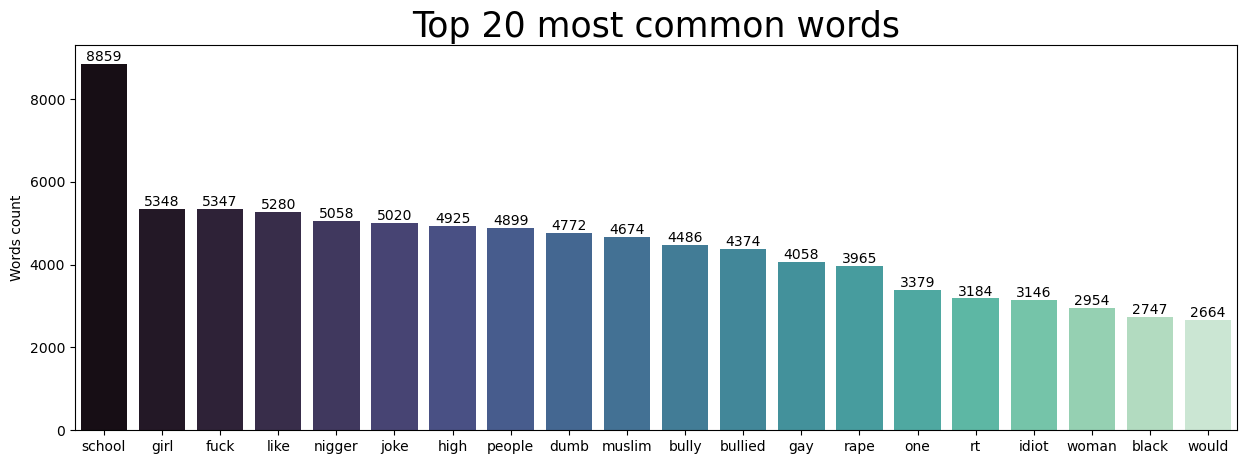

In [41]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [42]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

EMBEDDING_DIM = 200

word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 37556


In [43]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37556, 200)


In [44]:
X = tokenized_column
y = df['sentiment'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [47]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4966],
       [   2, 4705],
       [   3, 4625],
       [   4, 3886]])

In [48]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [49]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

In [50]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [51]:
BATCH_SIZE = 32

In [52]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# GRU Implementation

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs

# GRU Architecture
class GRU_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, gru_layers, is_bidirectional, dropout):
        super(GRU_Sentiment_Classifier, self).__init__()
        
        # Parameters
        self.num_layers = gru_layers
        self.hidden_dim = hidden_dim
        self.is_bidirectional = is_bidirectional
        
        # Layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding Layer
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=gru_layers, batch_first=True, bidirectional=is_bidirectional)  # GRU Layer
        self.self_attention = SelfAttention(hidden_dim * (2 if is_bidirectional else 1))  # Self-Attention Layer
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)  # Linear Layer
        self.dropout = nn.Dropout(dropout)  # Dropout Layer
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax Layer

    def forward(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        gru_out, hidden = self.gru(x, hidden)
        attended_out = self.self_attention(gru_out)
        out = self.fc(attended_out)
        return self.softmax(out), hidden

    def init_hidden(self, batch_size):
        num_directions = 2 if self.is_bidirectional else 1
        return torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim).to(device)
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = GRU_Sentiment_Classifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=256,
    num_classes=5,
    gru_layers=1,
    is_bidirectional=True,
    dropout=0.5
)
model.to(device)

# Example setup for loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        hidden = model.init_hidden(inputs.size(0)).to(device)
        outputs, _ = model(inputs, hidden)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Evaluation on the validation set
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        hidden = model.init_hidden(inputs.size(0)).to(device)
        outputs, _ = model(inputs, hidden)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
validation_accuracy = total_correct / total_samples
print(f'Validation Accuracy: {validation_accuracy}')

# Evaluation on the test set
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        hidden = model.init_hidden(inputs.size(0)).to(device)
        outputs, _ = model(inputs, hidden)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy}')


GRU_Sentiment_Classifier(
  (embedding): Embedding(37556, 200)
  (gru): GRU(200, 256, batch_first=True, bidirectional=True)
  (self_attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=512, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)
Epoch 1, Loss: 0.37069910339830325
Epoch 2, Loss: 0.22917856827454397
Epoch 3, Loss: 0.1886557981200602
Epoch 4, Loss: 0.15884273125413012
Epoch 5, Loss: 0.13429569399000965
Epoch 6, Loss: 0.11457278743257811
Epoch 7, Loss: 0.09403655434453724
Epoch 8, Loss: 0.08305634744554559
Epoch 9, Loss: 0.07653618566834607
Epoch 10, Loss: 0.06562333001049252
Validation Accuracy: 0.9280041436464088
Test Accuracy: 0.9280973451327433
